In [6]:
import numpy as np
%matplotlib inline  
import glob,h5py,os,re
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth']=2.5
mpl.rcParams['lines.markersize']=8
mpl.rcParams['text.usetex']=True
mpl.rcParams['text.latex.unicode']=True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['text.latex.preamble']= ['\usepackage{amsfonts}','\usepackage{amsmath}']
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize']=20
mpl.rcParams['legend.fontsize']=20
#http://stackoverflow.com/questions/22408237/named-colors-in-matplotlib
import cPickle as pickle
from datasets.synthp import params_synthetic

#visualize synthetic results

#dataset = 'synthetic10';maxEPOCH = 1000
dataset = 'synthetic11';maxEPOCH = 800

SAVEDIR = '../../expt-synthetic-fast/chkpt-'+dataset
DATADIR = '../../datasets/synthetic/'

def getHDF5Data(f):
    ff = h5py.File(f,mode='r')
    alldata = {}
    for k in ff.keys():
        alldata[k] = ff[k].value
    return alldata
def getPKLData(f):
    with open(f,'rb') as f:
        data = pickle.load(f)
    return data
def getCode(f):
    iMap = {'structured':'ST','mean_field':'MF'}
    vMap = {'lstmlr':'LR','lstm':'L','lstmr':'R'}
    inference_model = re.compile('-inf-(structured|mean_field)-')
    var_model = re.compile('-vm-(lstmlr|lstm|lstmr)-')
    return iMap[inference_model.findall(f)[0]]+'-'+vMap[var_model.findall(f)[0]]

bline = '../../expt-synthetic-fast/baselines/'+dataset+'-baseline.h5'
baseline = getHDF5Data(bline)

from datasets.load import loadDataset
dset  = loadDataset(dataset)
print dset['mask_train'].shape
#Point it to a top level directory

#Visualize the train rmse/bound and validation rmse/bound
#Visualize train reconstructions and validation reconstructions

Found:  /data/ml2/rahul/theanomodels/datasets/synthetic//synthetic11.h5
(5000, 25)


In [3]:
print params_synthetic[dataset]['docstr'], baseline.keys(),baseline['train_rmse'],baseline['train_ll'][0]/dset['mask_train'].sum()
print params_synthetic[dataset]['baseline']

$z_t\sim\mathcal{N}(2\sin(lpha z_{t-1})+z_{t-1},5)$
$x_t\sim\mathcal{N}(0.5z_t,5)$ [u'test_rmse', u'valid_mu', u'test_cov', u'train_cov', u'valid_rmse', u'test_ll', u'train_rmse', u'valid_cov', u'train_mu', u'train_ll', u'test_mu', u'valid_ll'] [ 2.14897633] 0.0
UKF


IOError: Unable to open file (Unable to open file: name = '../../datasets/synthetic//synthetic11.h5', errno = 2, error message = 'no such file or directory', flags = 0, o_flags = 0)

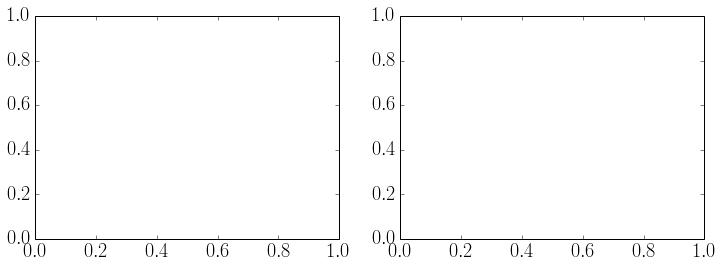

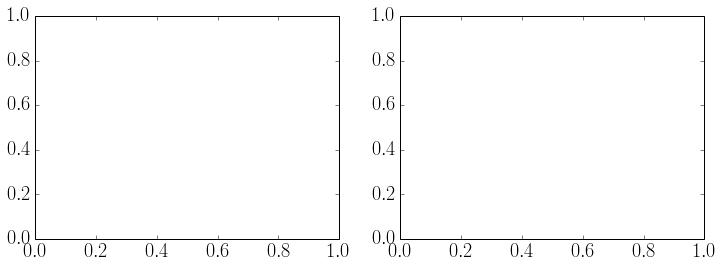

In [7]:
getepoch = re.compile("-EP(.*)-")
MAXEPOCH = 2000
paramconfig =''

markers  = {}
markers['ST-L']  = 'v'
markers['ST-LR'] = '<'
markers['ST-R']  = '>'
markers['MF-L']  = '8'
markers['MF-LR'] = '1'
markers['MF-R']  = 'p'
markers['x']  = 's'
markers['z']  = 's'
markers['KF'] = 's'

colors   = {}
colors['ST-L']  = 'k'
colors['ST-LR'] = 'b'
colors['ST-R']  = 'g'
colors['MF-L']  = 'y'
colors['MF-LR'] = 'r'
colors['MF-R']  = 'c'
colors['x']  = '#FF6347'
colors['z']  = '#FF6347'
colors['KF'] = '#C0C0C0'

def plotBounds(ax, x, y,c, m, label = None):
    ax.plot(x,y,label = label,marker =m, color=c)
def estimateMSE(mu_posterior, true_z):
    err_sum = np.square(mu_posterior-true_z.repeat(mu_posterior.shape[2],2)).sum(0,keepdims=True).sum(1,keepdims=True)
    rmse = np.sqrt(err_sum/float(mu_posterior.shape[0]*mu_posterior.shape[1])).squeeze()
    assert rmse.shape[0]==mu_posterior.shape[2],'Shape not matched'
    return rmse

#Train and validate bounds
fig_train,axlist_train = plt.subplots(1,2,figsize = (12,4))
fig_valid,axlist_valid = plt.subplots(1,2,figsize = (12,4))
for f in glob.glob(SAVEDIR+'/*'+paramconfig+'*-final.h5'):
    synthData= getHDF5Data(DATADIR+'/'+dataset+'.h5')
    code    = getCode(f)
    if code in ['MF-R','ST-L']:
        continue
    alldata = getHDF5Data(f)
    config  = getPKLData(f.replace('final','config').replace('h5','pkl'))
    X_Y     = alldata['train_bound'][10:,:][::config['savefreq'],:]
    idxMax  = np.where(X_Y[:,0]>maxEPOCH)[0][0]
    plotBounds(axlist_train.ravel()[1],X_Y[:idxMax,0],X_Y[:idxMax,1],colors[code], markers[code],label = code)
    X_Y     = alldata['valid_bound'][1:,:]
    idxMax  = np.where(X_Y[:,0]>maxEPOCH)[0][0]
    plotBounds(axlist_valid.ravel()[1],X_Y[:idxMax,0],X_Y[:idxMax,1],colors[code], markers[code],label = code)
    print alldata['mu_posterior_train'].shape,synthData['train_z'].shape
    
    rmse_train = estimateMSE(alldata['mu_posterior_train'],synthData['train_z'])
    rmse_valid = estimateMSE(alldata['mu_posterior_valid'],synthData['valid_z'])
    X          = np.arange(len(rmse_train))*config['savefreq']
    idxMax  = np.where(X>maxEPOCH)[0][0]
    plotBounds(axlist_train.ravel()[0],X[:idxMax],rmse_train[:idxMax], colors[code], markers[code],label = code)
    plotBounds(axlist_valid.ravel()[0],X[:idxMax],rmse_valid[:idxMax], colors[code], markers[code],label = code)

def plotHorizontal(ax, value, l, m, c):
    L = int(ax.get_xlim()[1])
    X = np.arange(0,L,200)
    ax.plot(X,np.array([value]*len(X)),label=l, marker =m, color=c)
    
#Add in plots for KF 
if params_synthetic[dataset]['baseline']=='KF':
    bline_train_ll = -baseline['train_ll'][0]/dset['mask_train'].sum()
    plotHorizontal(axlist_train.ravel()[1], bline_train_ll, 'KF', markers['KF'], colors['KF'])
    bline_valid_ll = -baseline['valid_ll'][0]/dset['mask_valid'].sum()
    plotHorizontal(axlist_valid.ravel()[1], bline_valid_ll, 'KF', markers['KF'], colors['KF'])

ax = axlist_train.ravel()[0]
bline_train_rmse = baseline['train_rmse']
baseline_label = params_synthetic[dataset]['baseline']
if baseline_label=='KF':
    baseline_label+=' [Exact Inference]'
plotHorizontal(axlist_train.ravel()[0], bline_train_rmse, baseline_label, 
               markers['KF'], colors['KF'])

ax = axlist_valid.ravel()[0]
bline_valid_rmse = baseline['valid_rmse']
plotHorizontal(axlist_valid.ravel()[0], bline_valid_rmse, baseline_label, 
               markers['KF'], colors['KF'])

print params_synthetic[dataset].keys()
ax = axlist_train.ravel()[0]
ax.set_xlabel('Epochs')
ax.set_ylabel('Train RMSE')
ax.set_ylim([1,6])
#ax.set_title(params_synthetic[dataset]['docstr'])
ax = axlist_train.ravel()[1]
ax.set_title(params_synthetic[dataset]['docstr'])
ax.set_xlabel('Epochs')
ax.set_ylabel('Train Upper Bound')
ax = axlist_valid.ravel()[0]
ax.set_xlabel('Epochs')
ax.set_ylabel('Validate RMSE')
ax.set_ylim([1,6])
#ax.set_title(params_synthetic[dataset]['docstr'])
ax = axlist_valid.ravel()[1]
ax.set_xlabel('Epochs')
ax.set_ylabel('Validate Upper Bound')
ax.set_title(params_synthetic[dataset]['docstr'])

axlist_train[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.4),ncol=3, frameon=False)
plt.figure(fig_train.number)
plt.savefig(dataset+'-train-bound.pdf',bbox_inches='tight')
axlist_valid[0].legend(loc='upper center', bbox_to_anchor=(0.6, 1.4),ncol=3, frameon=False)
plt.figure(fig_valid.number)
#plt.savefig(dataset+'-valid-bound.pdf',bbox_inches='tight')

[130 291  37]


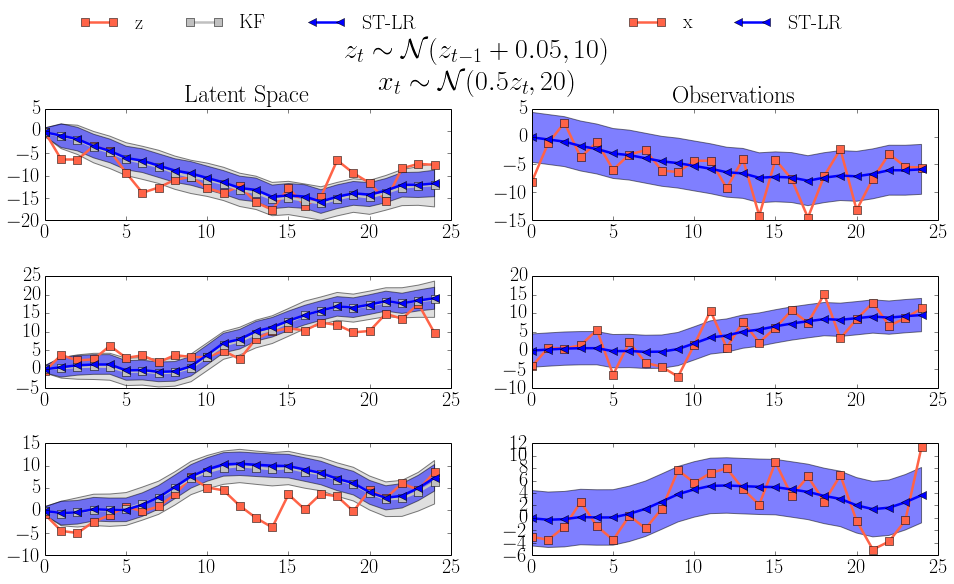

In [73]:
#Reconstructions
MARKER  = -1
nplots  = 3

#Train Reconstructions
fig,axlist  = plt.subplots(nplots,2,figsize = (16,8))
plt.suptitle(params_synthetic[dataset]['docstr'],fontsize=28,y=1.02)
fig.subplots_adjust(hspace=.5)
np.random.seed(3)
idxlist     = np.random.permutation(500)[:nplots]
print idxlist

def plotRecons(axlist, data, idxlist, c,m,label = None):
    for idx,n in enumerate(idxlist):
        Y = data[n,:]
        X = np.arange(len(Y))
        axlist[idx].plot(X,Y,color=c,marker=m,label=label)

def plotMuCov(axlist, data, stdData, idxlist, c,m,label = None):
    for idx,n in enumerate(idxlist):
        Y = data[n,:]
        X = np.arange(len(Y))
        std = stdData[n,:]
        axlist[idx].plot(X,Y,color=c,marker=m,label=label)
        axlist[idx].fill_between(X, Y+std, Y-std, facecolor=c, alpha=0.5)
        
for fnum,f in enumerate(glob.glob(SAVEDIR+'/*'+paramconfig+'*-final.h5')):
    synthData= getHDF5Data(DATADIR+'/'+dataset+'.h5')
    code    = getCode(f)
    if fnum==0:
        #Plot the original data
        mus_method = synthData['train_z'].squeeze()
        x_method = synthData['train'].squeeze()
        plotRecons(axlist[:,0], mus_method, idxlist, colors['z'],markers['z'],label='z')
        plotRecons(axlist[:,1], x_method, idxlist, colors['x'],markers['x'],label='x')
        #Plot baseline
        mus_method = baseline['train_mu'].squeeze()
        std_method = np.sqrt(baseline['train_cov'].squeeze())
        plotMuCov(axlist[:,0], mus_method,std_method, idxlist, colors['KF'],markers['KF'],
                  label=params_synthetic[dataset]['baseline'])
        
    if code not in ['ST-LR']:
        continue
    alldata = getHDF5Data(f)
    mus_method = alldata['mu_posterior_train'][:,:,MARKER].squeeze()
    std_method = np.sqrt(alldata['cov_posterior_train'][:,:,MARKER])
    x_method   = params_synthetic[dataset]['obs_fxn'](mus_method)
    std_x_method= np.ones_like(x_method)*np.sqrt(params_synthetic[dataset]['obs_cov'])
    
    plotMuCov(axlist[:,0], mus_method,std_method, idxlist, colors[code],markers[code],label=code)
    plotMuCov(axlist[:,1], x_method,std_x_method, idxlist, colors[code],markers[code],label=code)

#Also add exact inference to the plot
ax = axlist[0,0]
ax.set_title('Latent Space')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2),ncol=3, frameon=False)

ax = axlist[0,1]
ax.set_title('Observations')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2),ncol=3, frameon=False)
plt.savefig(dataset+'-vis.pdf',bbox_inches='tight')

[130 291  37]


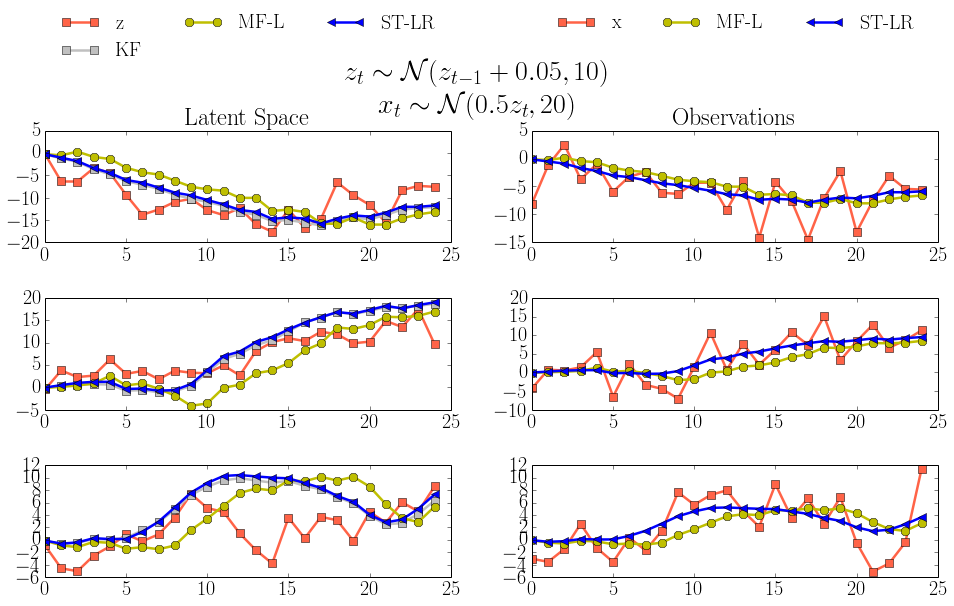

In [74]:
#Reconstructions
MARKER  = -1
nplots  = 3

#Train Reconstructions
fig,axlist  = plt.subplots(nplots,2,figsize = (16,8))
plt.suptitle(params_synthetic[dataset]['docstr'],fontsize=28,y=1.02)
fig.subplots_adjust(hspace=.5)
np.random.seed(3)
idxlist     = np.random.permutation(500)[:nplots]
print idxlist

def plotRecons(axlist, data, idxlist, c,m,label = None):
    for idx,n in enumerate(idxlist):
        Y = data[n,:]
        X = np.arange(len(Y))
        axlist[idx].plot(X,Y,color=c,marker=m,label=label)

def plotMuCov(axlist, data, stdData, idxlist, c,m,label = None):
    for idx,n in enumerate(idxlist):
        Y = data[n,:]
        X = np.arange(len(Y))
        std = stdData[n,:]
        axlist[idx].plot(X,Y,color=c,marker=m,label=label)
        axlist[idx].fill_between(X, Y+std, Y-std, facecolor=c, alpha=0.5)
        
for fnum,f in enumerate(glob.glob(SAVEDIR+'/*'+paramconfig+'*-final.h5')):
    synthData= getHDF5Data(DATADIR+'/'+dataset+'.h5')
    code    = getCode(f)
    if fnum==0:
        #Plot the original data
        mus_method = synthData['train_z'].squeeze()
        x_method = synthData['train'].squeeze()
        plotRecons(axlist[:,0], mus_method, idxlist, colors['z'],markers['z'],label='z')
        plotRecons(axlist[:,1], x_method, idxlist, colors['x'],markers['x'],label='x')
        #Plot baseline
        mus_method = baseline['train_mu'].squeeze()
        plotRecons(axlist[:,0], mus_method, idxlist, colors['KF'],markers['KF'],
                  label=params_synthetic[dataset]['baseline'])
        
    if code not in ['ST-LR','MF-L']:
        continue
    alldata = getHDF5Data(f)
    mus_method = alldata['mu_posterior_train'][:,:,MARKER].squeeze()
    x_method   = params_synthetic[dataset]['obs_fxn'](mus_method)
    plotRecons(axlist[:,0], mus_method, idxlist, colors[code],markers[code],label=code)
    plotRecons(axlist[:,1], x_method, idxlist, colors[code],markers[code],label=code)

#Also add exact inference to the plot
ax = axlist[0,0]
ax.set_title('Latent Space')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2.2),ncol=3, frameon=False)

ax = axlist[0,1]
ax.set_title('Observations')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 2.2),ncol=3, frameon=False)
plt.savefig(dataset+'-vis-means.pdf',bbox_inches='tight')

In [ ]:
## SAMPLES FROM THE DATA DISTRIBUTION

def sampleGaussian(mu,cov):
    return mu + np.random.randn(*mu.shape)*np.sqrt(cov)
#Sampling from the generative distribution
T=200

fig, axlist = plt.subplots(nplots,1,figsize=(8,10))

for n in range(nplots):
    z_prev = sampleGaussian(np.zeros((1,1))+params_synthetic[dataset]['init_mu'],
                            params_synthetic[dataset]['init_cov'])
    all_z =[z_prev]
    for t in range(T-1):
        z_prev = sampleGaussian(params_synthetic[dataset]['trans_fxn'](z_prev),
                                params_synthetic[dataset]['trans_cov'])
        all_z.append(z_prev)
    z = np.concatenate(all_z,axis=1)
    x = sampleGaussian(params_synthetic[dataset]['obs_fxn'](z),params_synthetic[dataset]['obs_cov'])
    axlist.ravel()[n].plot(range(T),z.ravel(),label = 'z',marker ='s', color='b',markersize=4)
    axlist.ravel()[n].plot(range(T),x.ravel(),label = 'x',marker ='<', color='g',markersize=3)
axlist.ravel()[0].set_title(params_synthetic[dataset]['docstr'])